In [1]:
import tensorflow as tf
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.utils import shuffle

In [3]:
def pad_and_concat(sequences):  # sequences shape: [batch_size, len, dims...] -> ([batch_size, maxlen, dims...], [len])
    arrays = [np.asarray(seq) for seq in sequences]
    lengths = np.asarray([array.shape[0] for array in arrays], dtype=np.int32)
    maxlen = np.max(lengths)
    arrays = [np.pad(array, [(0, maxlen - array.shape[0]), (0, 0)], 'constant', constant_values=0) for array in arrays]
    return np.asarray(arrays), lengths
    

In [4]:
SAMPLE = 10000
VARIABLE_NUM = 4
EMBEDDING_SIZE = 8
CLAUSE_SIZE = 3
CLAUSE_NUM = 30
LSTM_STATE_SIZE = 8
batch_size = 6
POLICY_LOSS_WEIGHT = 1
SAT_LOSS_WEIGHT = 1

In [5]:
def assert_shape(matrix, shape: list):
    act_shape = matrix.get_shape().as_list()
    assert act_shape == shape, "got shape {}, expected {}".format(act_shape, shape)

In [6]:
class Graph:
    def __init__(self):
        self.inputs = tf.placeholder(tf.int32, shape=(batch_size, None, CLAUSE_SIZE), name='inputs')
        self.lengths = tf.placeholder(tf.int32, shape=(batch_size,), name='lengths')
        self.policy_labels = tf.placeholder(tf.float32, shape=(batch_size, VARIABLE_NUM*2), name='policy_labels')
        self.sat_labels = tf.placeholder(tf.float32, shape=(batch_size,), name='sat_labels')
        
        vars_ = tf.abs(self.inputs)
        signs = tf.cast(tf.sign(self.inputs), tf.float32)  # shape: [batch_size, None, CLAUSE_SIZE]

        embeddings = tf.Variable(tf.random_uniform([VARIABLE_NUM + 1, EMBEDDING_SIZE], -1., 1), name='embeddings')

        var_embeddings = tf.nn.embedding_lookup(embeddings, vars_)
        # var_embeddings shape: [None, None, CLAUSE_SIZE, EMBEDDING_SIZE]
        
        clause_preembeddings = tf.concat(
            [tf.reshape(var_embeddings, [batch_size, -1, CLAUSE_SIZE * EMBEDDING_SIZE]), 
             signs],
            axis=2)
        
        PREEMBEDDING_SIZE = EMBEDDING_SIZE * CLAUSE_SIZE + CLAUSE_SIZE
        assert_shape(clause_preembeddings, 
                     [batch_size, None, PREEMBEDDING_SIZE])
        
        clause_w = tf.Variable(tf.random_normal(
            [PREEMBEDDING_SIZE, EMBEDDING_SIZE]), name='clause_w')
        clause_b = tf.Variable(tf.random_normal([EMBEDDING_SIZE]), name='clause_b')
        clause_embeddings = tf.reshape(tf.sigmoid(
            tf.reshape(clause_preembeddings, [-1, PREEMBEDDING_SIZE]) @ clause_w + clause_b), 
                                       [batch_size, -1, EMBEDDING_SIZE])
        # shape: [None, None, EMBEDDING_SIZE]
        
        lstm = tf.contrib.rnn.BasicLSTMCell(LSTM_STATE_SIZE)
        hidden_state = tf.zeros([batch_size, LSTM_STATE_SIZE])
        current_state = tf.zeros([batch_size, LSTM_STATE_SIZE])
        state = hidden_state, current_state
        
        _, lstm_final_state = tf.nn.dynamic_rnn(lstm, clause_embeddings, dtype=tf.float32, 
                                               sequence_length=self.lengths
                                               )
        formula_embedding = lstm_final_state.h
            
        assert_shape(formula_embedding, [batch_size, LSTM_STATE_SIZE])
            
        softmax_w = tf.Variable(tf.random_normal([LSTM_STATE_SIZE, VARIABLE_NUM*2]), name='softmax_w')
        softmax_b = tf.Variable(tf.random_normal([VARIABLE_NUM*2]), name='softmax_b')
        
        sat_w = tf.Variable(tf.random_normal([LSTM_STATE_SIZE, 1]), name='sat_w')
        sat_b = tf.Variable(tf.random_normal([1]), 'sat_b')
        
        self.policy_logits = formula_embedding @ softmax_w + softmax_b
        
        self.sat_logits = tf.squeeze(formula_embedding @ (sat_w), axis=1) + sat_b
        
        # zero out policy for test when UNSAT
        # requires sat_labels to be provided, so needs to be a separate tensor in order 
        # for inference to work
        self.policy_logits_for_test = tf.expand_dims(self.sat_labels, axis=1) * self.policy_logits
        
        self.policy_loss = tf.losses.sigmoid_cross_entropy(
            self.policy_labels, self.policy_logits_for_test) 
        self.policy_probabilities = tf.sigmoid(self.policy_logits)
        
        self.sat_loss = tf.losses.sigmoid_cross_entropy(self.sat_labels, self.sat_logits)
        self.sat_probabilities = tf.sigmoid(self.sat_logits)
        
        self.policy_error = tf.reduce_mean(tf.abs(
            tf.round(self.policy_probabilities) - self.policy_labels))
        self.sat_error = tf.reduce_mean(tf.abs(
            tf.round(self.sat_probabilities) - self.sat_labels))
        
        self.loss = SAT_LOSS_WEIGHT * self.sat_loss + POLICY_LOSS_WEIGHT * self.policy_loss
        
        tf.summary.scalar("loss", self.loss)
        tf.summary.scalar("policy_loss", self.policy_loss)
        tf.summary.scalar("policy_error", self.policy_error)
        tf.summary.scalar("sat_loss", self.sat_loss)
        tf.summary.scalar("sat_error", self.sat_error)

tf.reset_default_graph()
model = Graph()

In [20]:
total_parameters = 0
for variable in tf.trainable_variables():
    # shape is an array of tf.Dimension
    shape = variable.get_shape()
    print(shape)
    print(len(shape))
    variable_parameters = 1
    for dim in shape:
        print(dim)
        variable_parameters *= dim.value
    print(variable_parameters)
    total_parameters += variable_parameters
print(total_parameters)


(5, 8)
2
5
8
40
(27, 8)
2
27
8
216
(8,)
1
8
8
(16, 32)
2
16
32
512
(32,)
1
32
32
(8, 8)
2
8
8
64
(8,)
1
8
8
(8, 1)
2
8
1
8
(1,)
1
1
1
889


In [7]:
np.set_printoptions(precision=2, suppress=True)

In [8]:
from cnf import get_random_kcnfs

In [9]:
def sat_array():
    for k in range(1, 6):
        for var_num in range(2, 5):
            for clause_num in range(3, 10):
                sat = {True: 0, False: 0}
                for _ in range(100):
                    sat[cnf.get_random_kcnf(k, var_num, clause_num).satisfiable()] += 1
                print(k, var_num, clause_num, sat)
# sat_array()

info: 200 3 4 30


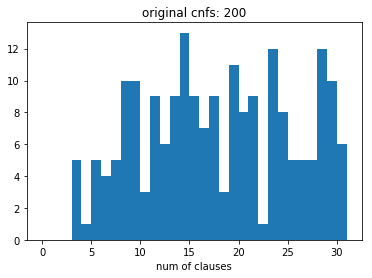

In [10]:
print("info:", SAMPLE, CLAUSE_SIZE, VARIABLE_NUM, CLAUSE_NUM)

cnfs = get_random_kcnfs(SAMPLE, CLAUSE_SIZE, VARIABLE_NUM, CLAUSE_NUM, min_clause_number=3)
plt.title("original cnfs: {}".format(len(cnfs)))
plt.hist([len(cnf.clauses) for cnf in cnfs], bins=range(CLAUSE_NUM+2))
plt.xlabel("num of clauses")
plt.show()
sat_labels = [cnf.satisfiable() for cnf in cnfs]
# plt.title("sat cnfs: {}".format(len(cnfs)))
# plt.hist([len(cnf.clauses) for cnf in cnfs], bins=range(CLAUSE_NUM+2))
# plt.xlabel("num of clauses")
# plt.show()
# print("#samples:", len(cnfs))
# assert len(cnfs) * 2 > SAMPLE

In [11]:
labels = []
for cnf, is_satisfiable in zip(cnfs, sat_labels):
    if is_satisfiable:
        correct_steps = cnf.get_correct_steps()
        label = []
        # for every variable, for true, then for false
        for v in range(1, VARIABLE_NUM+1):
            for sv in [v, -v]:
                result = 1.0 if sv in correct_steps else 0.0
                label.append(result)
        labels.append(label)
    else:
        labels.append([0 for _ in range(VARIABLE_NUM * 2)])
        
assert all(len(label) == 2*VARIABLE_NUM for label in labels)
sat_steps = sum(sum(label) for label in labels)
unsat_steps = len(cnfs)*2*VARIABLE_NUM - sat_steps
print("SAT/UNSAT steps: {} / {}".format(sat_steps, unsat_steps))
assert unsat_steps * 4 > sat_steps
print("labels generated")

SAT/UNSAT steps: 813.0 / 787.0
labels generated


In [12]:
print(len(cnfs))
print(len(labels))
print(len(sat_labels))

200
200
200


In [13]:
print(sat_labels)

[True, True, True, True, True, False, True, True, False, True, True, True, True, True, True, False, False, False, False, False, True, False, True, False, True, True, True, True, False, True, True, True, True, False, False, True, True, False, False, True, False, True, True, True, True, False, True, True, True, True, False, True, True, True, False, True, True, True, True, True, True, False, True, False, True, False, True, False, True, True, True, True, True, True, False, True, True, False, True, True, True, False, True, False, True, True, True, False, False, True, False, True, True, False, True, True, True, True, True, False, True, False, False, True, True, False, False, True, False, True, True, True, True, False, False, False, True, True, True, True, False, True, True, True, False, False, True, True, True, True, True, True, True, False, True, True, True, True, True, True, True, True, False, False, False, True, False, False, True, True, True, True, True, True, True, True, True, False, Fa

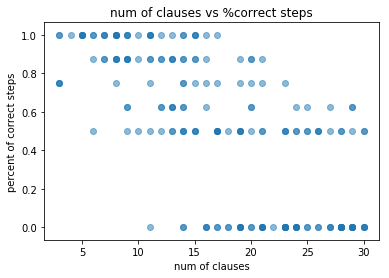

In [14]:
plt.title("num of clauses vs %correct steps")
plt.scatter([len(cnf.clauses) for cnf in cnfs], [sum(label)/2./VARIABLE_NUM for label in labels], alpha=0.5)
plt.xlabel("num of clauses")
plt.ylabel("percent of correct steps")
plt.show()

In [15]:
cnfs_train, cnfs_test, labels_train, labels_test, sat_labels_train, sat_labels_test = train_test_split(cnfs, labels, sat_labels)

In [16]:
def chunks(lists, chunk_size):
    return [[it[i:i + chunk_size] for it in lists] for i in range(0, len(lists[0]), chunk_size)]

In [19]:
import datetime
merged_summaries = tf.summary.merge_all()

SUMMARY_DIR = "summaries"
MODEL_NAME = "policyandval"
DATESTR = datetime.datetime.now().strftime("%y-%m-%d-%H%M%S")
SUMMARY_PREFIX = SUMMARY_DIR + "/" + MODEL_NAME + "-" + DATESTR
train_writer = tf.summary.FileWriter(SUMMARY_PREFIX + "-train")
test_writer = tf.summary.FileWriter(SUMMARY_PREFIX + "-test")

NAME = "{} {}-SATs with {} vars and {} clauses".format(len(cnfs), CLAUSE_SIZE, VARIABLE_NUM, CLAUSE_NUM)

with tf.Session() as sess:
    train_op = tf.train.AdamOptimizer(learning_rate=0.01).minimize(model.loss)
    sess.run(tf.global_variables_initializer())
    
    EPOCHS = 100
    global_step = 0
    for epoch_num in range(EPOCHS):
        print("Epoch", epoch_num)
        losses = []
        accs = []
        test_losses = []
        test_accs = []
        cnfs_train, labels_train, sat_labels_train = shuffle(cnfs_train, labels_train, sat_labels_train)
        for (batch_cnfs, batch_labels, batch_sat_labels) in chunks(
                (cnfs_train, labels_train, sat_labels_train), batch_size):
            if len(batch_cnfs) < batch_size:
                continue
            inputs, lengths = pad_and_concat([cnf.clauses for cnf in batch_cnfs])
            summary, _, loss, probs = sess.run([merged_summaries, train_op, model.loss, model.policy_probabilities], feed_dict={
                model.inputs: inputs,
                model.policy_labels: batch_labels,
                model.lengths: lengths,
                model.sat_labels: batch_sat_labels
            })
            train_writer.add_summary(summary, global_step)
            
            global_step += 1

        
        for (batch_cnfs, batch_labels, batch_sat_labels) in chunks(
                (cnfs_test, labels_test, sat_labels_test), batch_size):
            if len(batch_cnfs) < batch_size:
                continue
            inputs, lengths = pad_and_concat([cnf.clauses for cnf in batch_cnfs])
            summary, loss, probs = sess.run([merged_summaries, model.loss, model.policy_probabilities], feed_dict={
                model.inputs: inputs,
                model.policy_labels: batch_labels,
                model.lengths: lengths,
                model.sat_labels: batch_sat_labels
            })
            test_writer.add_summary(summary, global_step)
            


Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
